In [2]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.parallel
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import argparse
import scipy.io
import os

class MLP(nn.Module):
  def __init__(self, input_size, output_size, dropout= 0.000529, num_layers = 8, num_neurons = 2048):
        super(MLP, self).__init__()
        self.num_layers = num_layers
        self.layers = nn.ModuleList()
        self.bn_layers = nn.ModuleList()
        self.activation_fn = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        for i in range(num_layers):
          if i == 0:
            self.layers.append(nn.Linear(input_size, num_neurons))
            self.bn_layers.append(nn.BatchNorm1d(num_neurons))
          else:
            self.layers.append(nn.Linear(num_neurons // (2**(i-1)), num_neurons // (2**i)))
            self.bn_layers.append(nn.BatchNorm1d(num_neurons // (2**i)))
            #self.layers.append(nn.Linear(num_neurons, num_neurons))
            #self.bn_layers.append(nn.BatchNorm1d(num_neurons))

        # Try Relu also here after going through hyperparamter tuning
        self.output_layer = nn.Linear(num_neurons // (2**(num_layers-1)), output_size)
        #self.output_layer = nn.Linear(num_neurons, output_size)
        self.dropout = nn.Dropout(dropout)

  def forward(self, x):
      for i in range(self.num_layers):
        x = self.layers[i](x)
        x = self.bn_layers[i](x)
        x = self.dropout(x)
        x = self.activation_fn(x)

      x = self.output_layer(x)
      x = self.sigmoid(x)
      return x

file = 'Porsche/3L_NPC_scaled_32_25_synthetic.mat'
mat_data = scipy.io.loadmat(file)
#Get scaled input and scaled output data
#Min max Scaling
input_scaled = mat_data.get('input_scaled')
output_scaled = mat_data.get('output_scaled')
output_scaled = output_scaled[:,0:3]
input_size = input_scaled.shape[1]
output_size = output_scaled.shape[1]


print(output_scaled.shape)
# Load the trained model from the .pt file
model = MLP(input_size, output_size)  # Replace input_size and output_size with appropriate values
path = 'best_model_3L_NPC_r2score_0.99953_params_lr_ 0.0027_drop_0.000529_hypertuning.pt'
model.load_state_dict(torch.load(path)) #, map_location=torch.device('cpu')))
model.eval()
# Prepare the input data for prediction
input_data = torch.Tensor(input_scaled)
output_data = torch.Tensor(output_scaled)

(1569590, 3)


/tmp/ipykernel_126/3386859931.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


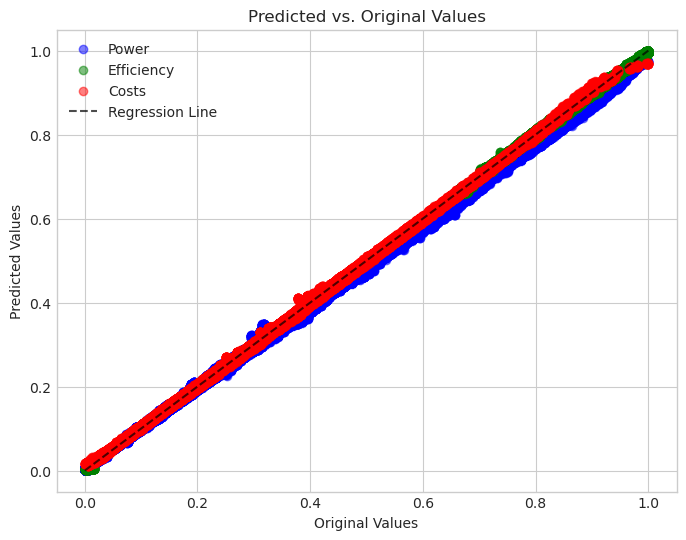

In [3]:
import numpy as np
plt.style.use('seaborn-whitegrid')
original_values = output_data[:, 0:3]

# Calculate the regression line
regression_line = np.linspace(original_values[:, 0].min(), original_values[:, 0].max(), 100)

# Perform inference to get predicted values
with torch.no_grad():
    predictions = model(input_data)

# Convert predicted and original values to NumPy arrays
predicted_values = predictions[:, 0:3]  # Assuming you want to plot the first three columns (power, efficiency, and costs)

# Plot the predicted values against the original values
plt.figure(figsize=(8, 6))
plt.scatter(original_values[:, 0], predicted_values[:, 0], label='Power', color='blue', alpha=0.5)
plt.scatter(original_values[:, 1], predicted_values[:, 1], label='Efficiency', color='green', alpha=0.5)
plt.scatter(original_values[:, 2], predicted_values[:, 2], label='Costs', color='red', alpha=0.5)

# Plot the regression line in black
plt.plot(regression_line, regression_line, color='black', linestyle='--', alpha=0.7, label='Regression Line')

plt.xlabel('Original Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Original Values')
plt.legend()
plt.grid(True)
plt.savefig('predicted_vs_original.png', bbox_inches='tight', dpi=500)
plt.show()

In [4]:
'''
# Perform inference to get predicted values
with torch.no_grad():
    predictions = model(input_data)

# Convert predicted and original values to NumPy arrays
predicted_values = predictions[:, 0:3]  # Assuming you want to plot the first three columns (power, efficiency, and costs)
original_values = output_data[:, 0:3]

# Plot the predicted values against the original values
plt.figure(figsize=(8, 6))
plt.scatter(original_values[:, 2], predicted_values[:, 2], label='Costs', color='red', alpha=0.5)

plt.xlabel('Original Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Original Values')
plt.legend()
plt.grid(True)
plt.show()
'''

"\n# Perform inference to get predicted values\nwith torch.no_grad():\n    predictions = model(input_data)\n\n# Convert predicted and original values to NumPy arrays\npredicted_values = predictions[:, 0:3]  # Assuming you want to plot the first three columns (power, efficiency, and costs)\noriginal_values = output_data[:, 0:3]\n\n# Plot the predicted values against the original values\nplt.figure(figsize=(8, 6))\nplt.scatter(original_values[:, 2], predicted_values[:, 2], label='Costs', color='red', alpha=0.5)\n\nplt.xlabel('Original Values')\nplt.ylabel('Predicted Values')\nplt.title('Predicted vs. Original Values')\nplt.legend()\nplt.grid(True)\nplt.show()\n"

In [5]:
'''
import matplotlib.pyplot as plt

# Create subplots for each variable
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Iterate over each variable
for i, variable in enumerate(['Power', 'Efficiency', 'Costs']):
    # Plot original values
    axs[i].scatter(original_values[:, i], original_values[:, i], marker='o', label=f'{variable} (Original)', color='blue', alpha=0.5)

    # Set the same axis limits
    min_value = original_values[:, i].min()
    max_value = original_values[:, i].max()
    axs[i].set_xlim(min_value, max_value)
    axs[i].set_ylim(min_value, max_value)

    # Add a 1:1 line
    axs[i].plot([min_value, max_value], [min_value, max_value], color='gray', linestyle='--', alpha=0.7)

    axs[i].set_xlabel(f'Original {variable} Values')
    axs[i].set_title(f'Original {variable} Values')
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.show()
'''

"\nimport matplotlib.pyplot as plt\n\n# Create subplots for each variable\nfig, axs = plt.subplots(1, 3, figsize=(15, 5))\n\n# Iterate over each variable\nfor i, variable in enumerate(['Power', 'Efficiency', 'Costs']):\n    # Plot original values\n    axs[i].scatter(original_values[:, i], original_values[:, i], marker='o', label=f'{variable} (Original)', color='blue', alpha=0.5)\n\n    # Set the same axis limits\n    min_value = original_values[:, i].min()\n    max_value = original_values[:, i].max()\n    axs[i].set_xlim(min_value, max_value)\n    axs[i].set_ylim(min_value, max_value)\n\n    # Add a 1:1 line\n    axs[i].plot([min_value, max_value], [min_value, max_value], color='gray', linestyle='--', alpha=0.7)\n\n    axs[i].set_xlabel(f'Original {variable} Values')\n    axs[i].set_title(f'Original {variable} Values')\n    axs[i].legend()\n    axs[i].grid(True)\n\nplt.tight_layout()\nplt.show()\n"

/tmp/ipykernel_126/3096037421.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


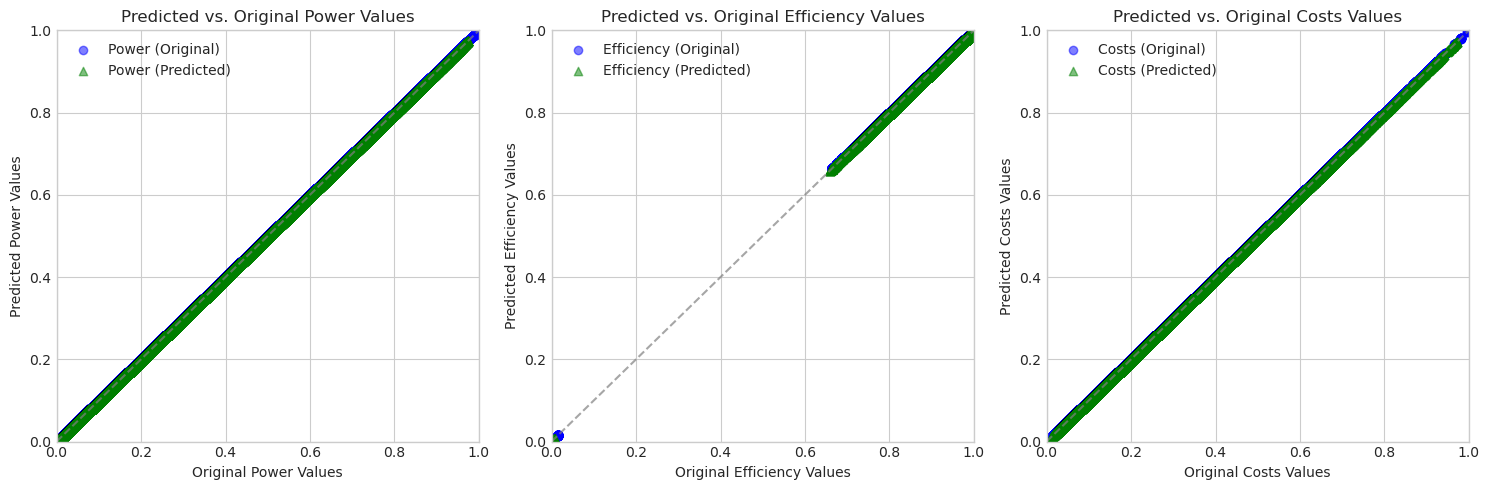

In [6]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
# Create subplots for each variable
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Iterate over each variable
for i, variable in enumerate(['Power', 'Efficiency', 'Costs']):
    # Plot original values
    axs[i].scatter(original_values[:, i], original_values[:, i], marker='o', label=f'{variable} (Original)', color='blue', alpha=0.5)

    # Plot predicted values
    axs[i].scatter(predicted_values[:, i], predicted_values[:, i], marker='^', label=f'{variable} (Predicted)', color='green', alpha=0.5)

    # Set the same axis limits
    min_value = min(original_values[:, i].min(), predicted_values[:, i].min())
    max_value = max(original_values[:, i].max(), predicted_values[:, i].max())
    axs[i].set_xlim(min_value, max_value)
    axs[i].set_ylim(min_value, max_value)

    # Add a 1:1 line
    axs[i].plot([min_value, max_value], [min_value, max_value], color='gray', linestyle='--', alpha=0.7)

    axs[i].set_xlabel(f'Original {variable} Values')
    axs[i].set_ylabel(f'Predicted {variable} Values')
    axs[i].set_title(f'Predicted vs. Original {variable} Values')
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.savefig('Regression_lines_overview_1', bbox_inches='tight', dpi=500)
plt.show()


/tmp/ipykernel_126/2730375109.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


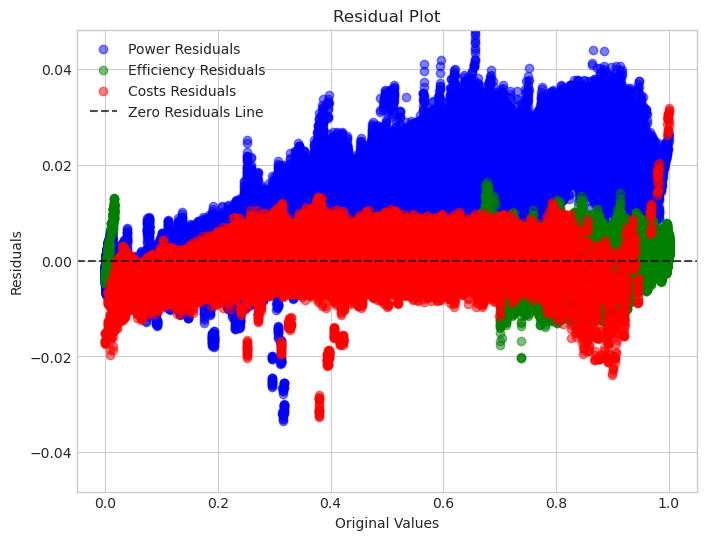

In [7]:
# Calculate residuals
residuals = original_values - predicted_values

# Set plot style and colors
plt.style.use('seaborn-whitegrid')
colors = ['blue', 'green', 'red']  # Define colors for each output

# Create the figure and axis
plt.figure(figsize=(8, 6))
ax = plt.gca()

# Plot residuals for each output
for i, label in enumerate(['Power', 'Efficiency', 'Costs']):
    plt.scatter(original_values[:, i], residuals[:, i], label=f'{label} Residuals', color=colors[i], alpha=0.5)

# Add a horizontal line at y=0
plt.axhline(y=0, color='black', linestyle='--', alpha=0.7, label='Zero Residuals Line')

# Set axis labels and title
plt.xlabel('Original Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')

# Set legend
plt.legend()

# Adjust plot limits for better visualization (optional)
plt.ylim([-max(abs(residuals.flatten())), max(abs(residuals.flatten()))])

# Add a grid
plt.grid(True)
plt.savefig('Residual_line_1', bbox_inches='tight', dpi=500)
# Show the plot
plt.show()
